In [88]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [89]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ("record") node for it
        dot.node(
            name=uid,
            label=f"{n.label.title() if n.label else 'Derived'} | value = {n.data:.4f} | grad = {n.grad:.4f}",
            shape="record",
        )
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [395]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        if self.label:
            return f"{self.label}=Value({self.data})"
        else:
            return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topological_sort = []
        visited = set()

        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_sort(child)
                topological_sort.append(v)

        build_topological_sort(self)
        self.grad = 1
        for node in reversed(topological_sort):
            node._backward()

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __rtruediv__(self, other):  # other / self
        return other * self ** -1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


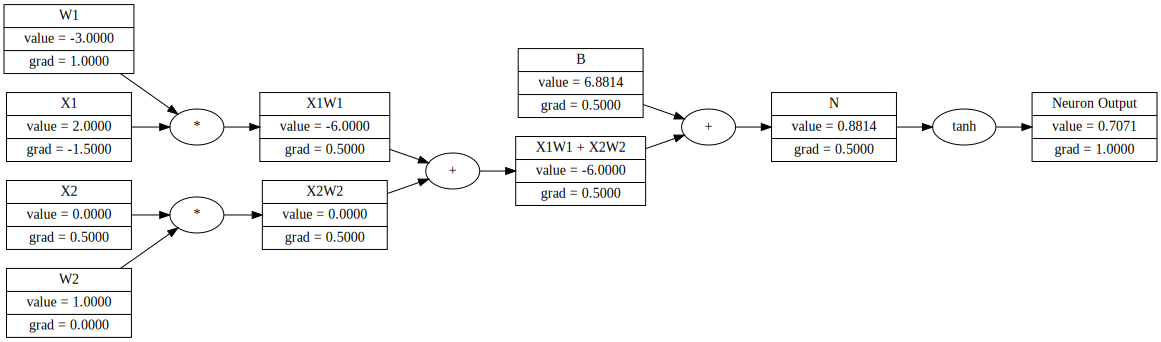

In [396]:
# inputs x1, x2
x1 = Value(2, label="x1")
x2 = Value(0, label="x2")
# weights of the neuron
w1 = Value(-3, label="w1")
w2 = Value(1, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "neuron output"

o.backward()

draw_dot(o)

In [397]:
import random

In [398]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [399]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8542338603953151, grad=0)

In [400]:
len(n.parameters())

41

In [401]:
xs = [
    [2., 3., 1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

ys = [1., -1., -1., 1.]

In [402]:
ypred = [n(x) for x in xs]
loss = sum([(ygt - yout) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.576997344050791, grad=0)

In [403]:
# run these 4 cells below iteratively - this is gradient descent

In [404]:
loss.backward()

In [405]:
for p in n.parameters():
    p.data -= 0.005 * p.grad

In [406]:
ypred = [n(x) for x in xs]
loss = sum([(ygt - yout) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.023061415862303, grad=0)

In [407]:
ypred

[Value(data=0.39703190301393737, grad=0),
 Value(data=0.612478303721597, grad=0),
 Value(data=0.4133251367191657, grad=0),
 Value(data=0.7511693993412747, grad=0)]

In [408]:
# redefine the network
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.43198305456814406, grad=0)

In [409]:
# now we will do an actual train loop
learning_rate = 0.05

for k in range(1, 101):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    if k % 10 == 0:
        print(f"Iteration {k} loss = {loss.data}")
    
    # remember to zero the grads before the backward pass
    for p in n.parameters():
        p.grad = 0

    # backward pass - update params
    loss.backward()
    for p in n.parameters():
        p.data -= learning_rate * p.grad

print("Done")
print(f"Final loss = {loss}")
print(f"Predictions: {[n(x) for x in xs]}")

Iteration 10 loss = 0.1838221258862376
Iteration 20 loss = 0.06332141490956586
Iteration 30 loss = 0.03640502131808837
Iteration 40 loss = 0.025093348205177536
Iteration 50 loss = 0.01897454010505304
Iteration 60 loss = 0.01517498253552239
Iteration 70 loss = 0.012600259555505986
Iteration 80 loss = 0.010747030729715603
Iteration 90 loss = 0.00935285138167801
Iteration 100 loss = 0.008267996019906099
Done
Final loss = Value(data=0.008267996019906099, grad=1)
Predictions: [Value(data=0.9439804438155275, grad=0), Value(data=-0.955108098866416, grad=0), Value(data=-0.95653959138758, grad=0), Value(data=0.966378814804373, grad=0)]


In [410]:
l = [(ygt - yout) ** 2 for ygt, yout in zip(ys, ypred)]
l

[Value(data=0.0031742982566757595, grad=0),
 Value(data=0.0020370791433969707, grad=0),
 Value(data=0.0019123149887559244, grad=0),
 Value(data=0.0011443036310774455, grad=0)]

In [411]:
s = sum(l)
print(s)
print(l[0] + l[1] + l[2] + l[3])

Value(data=0.008267996019906099, grad=0)
Value(data=0.008267996019906099, grad=0)


Value(3.6557701999770984)